## Install packages required

In [0]:
%tensorflow_version 2.x
!pip install tensorflow==2.1.0
!pip install keras==2.3.0
!pip install -U keras-tuner

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 450kB 47.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=8390547be749167018d4e9038f52e67ba97165c3bb45364666d11a50d2db98db
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1
     |████████████████████████████████| 378kB 11.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
     |██████████

## Create the WAME optimizer for use within the later training
First we create the WAME optimizer within Tensorflow using the existing optimizers as a framework to build upon.

In [0]:
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import training_ops
from tensorflow.python.util.tf_export import keras_export
import numpy as np
import tensorflow as tf
import random

import pandas as pd
from scipy.io import loadmat 
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, BatchNormalization, Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
from kerastuner.tuners import *
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters
import pickle
import h5py

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import string
import seaborn as sn


class WAMEprop(optimizer_v2.OptimizerV2):
	"""WAME optimizer.
	It is recommended to leave the parameters of this optimizer at their default values as these have been
	shown empircally to deliver good results (except the learning rate, which can be freely tuned).
	The algorithm has been adapated slightly from the original paper to replace \frac{1}{\theta} with \frac{1}{\sqrt{\theta}} after 
	speaking with the algorithm developers. 
	# Arguments
		learning_rate: float >= 0. Base learning rate.
		alpha: float >= 0. Decay rate of the exponentially weighted moving average.
		eta_plus: float > 0. Multiplicative term of the acceleration factor for the case of a positive gradient product.
		eta_minus: float > 0. Multiplicative term of the acceleration factor for the case of a negative gradient product.
		zeta_min: float > 0. Lower bounding value for the accerlation factor.
		zeta_max: float > 0. Upper bounding value for the acceleration factor.
		epsilon: float > 0. A very small fudge factor requried to avoid a possible division by zero error.
	# References
		- [wame: Training Convolutional Networks with Weight–wise Adaptive Learning Rates]
		(https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2017-50.pdf)
	"""

	def __init__(self, learning_rate=0.0001, alpha = 0.9, eta_plus = 1.2, eta_minus = 0.1, zeta_min = 0.01, zeta_max = 100, epsilon = 1e-11, **kwargs):
		super(WAMEprop, self).__init__(**kwargs)
		self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
		self._set_hyper("alpha", alpha)
		self._set_hyper("eta_plus", eta_plus)
		self._set_hyper("eta_minus", eta_minus)
		self._set_hyper("zeta_min", zeta_min)
		self._set_hyper("zeta_max", zeta_max)
		self.epsilon = epsilon
 
	def _create_slots(self, var_list):
		for var in var_list:
			self.add_slot(var, "zetas")
			self.add_slot(var, "zeds")
			self.add_slot(var, "thetas")
			self.add_slot(var, "old_grads")

	def _prepare_local(self, var_device, var_dtype, apply_state):
		super(WAMEprop, self)._prepare_local(var_device, var_dtype, apply_state)

		alpha = array_ops.identity(self._get_hyper("alpha", var_dtype))
		eta_plus = array_ops.identity(self._get_hyper("eta_plus", var_dtype))
		eta_minus = array_ops.identity(self._get_hyper("eta_minus", var_dtype))
		zeta_max = array_ops.identity(self._get_hyper("zeta_max", var_dtype))
		zeta_min = array_ops.identity(self._get_hyper("zeta_min", var_dtype))
		apply_state[(var_device, var_dtype)].update(
			dict(
				epsilon=ops.convert_to_tensor_v2(self.epsilon, var_dtype),
				alpha=alpha,
				eta_plus = eta_plus,
				eta_minus = eta_minus,
				zeta_max = zeta_max,
				zeta_min = zeta_min,
				one_minus_alpha = 1 - alpha))

	def _resource_apply_dense(self, grad, var, apply_state=None):
		var_device, var_dtype = var.device, var.dtype.base_dtype
		coefficients = ((apply_state or {}).get((var_device, var_dtype))
						or self._fallback_apply_state(var_device, var_dtype))

		zeta =  self.get_slot(var, 'zetas')
		zed =  self.get_slot(var, 'zeds')
		theta =  self.get_slot(var, 'thetas')
		old_grad =  self.get_slot(var, 'old_grads')

		new_z = tf.where(
			math_ops.Equal(x = grad * old_grad, y = 0),
		zeta,
		tf.where(math_ops.Greater(x = grad * old_grad, y = 0),
			x = math_ops.Minimum(x = zeta * coefficients['eta_plus'], y = coefficients['zeta_max']),
			y = math_ops.Maximum(x = zeta * coefficients['eta_minus'], y = coefficients['zeta_min'])
		)
		)
			
		new_z = state_ops.assign(zeta, new_z, use_locking=self._use_locking)

		new_zed = (coefficients["alpha"] * zed)  + (coefficients["one_minus_alpha"]*new_z)
		new_zed = state_ops.assign(zed, new_zed, use_locking=self._use_locking)

		new_t = (coefficients["alpha"] * theta)  + (coefficients["one_minus_alpha"]*math_ops.square(grad))
		new_t = state_ops.assign(theta, new_t, use_locking=self._use_locking)

		var_t  = var - (coefficients["lr_t"] * new_zed * grad * (1/(math_ops.Sqrt(x = new_t) +coefficients["epsilon"])))

		old_grad = state_ops.assign(old_grad, grad, use_locking=self._use_locking)

		return state_ops.assign(var, var_t, use_locking=self._use_locking).op

	def _resource_apply_sparse(self, grad, var):
		raise NotImplementedError("Sparse gradient updates are not supported.")
	
	def get_config(self):
		config = super(WAMEprop, self).get_config()
		config.update({'learning_rate': self._serialize_hyperparameter("learning_rate"),
				  'alpha': self._serialize_hyperparameter("alpha"),
				  'eta_plus': self._serialize_hyperparameter("eta_plus"),
				  'eta_minus': self._serialize_hyperparameter("eta_minus"),
				  'zeta_min': self._serialize_hyperparameter("zeta_min"),
				  'zeta_max': self._serialize_hyperparameter("zeta_max") 
				  })
		return config


## Import data and split
Due to the data being stored in the a matlab file, we take the majority of this import code from https://github.com/srijan14/keras-handwritten-character-recognition/blob/master/src/model.py to simplify the approach and do the required pre-processing to rotate and transpose the data.

In [0]:
def load_data(file, img_rows = 28, img_cols = 28, log = False):
  letters = loadmat(file)
  # Loading Training Data
  X_train = letters["dataset"][0][0][0][0][0][0]
  y_train = letters["dataset"][0][0][0][0][0][1]
  X_train = X_train.astype('float32')
  X_train /= 255.0

  ##Loading Testing Data
  X_test = letters["dataset"][0][0][1][0][0][0]
  y_test = letters["dataset"][0][0][1][0][0][1]
  X_test = X_test.astype('float32')
  X_test /= 255.0

  # one-hot encoding:
  Y_train = to_categorical(y_train - 1)
  Y_test = to_categorical(y_test - 1)

  # input image dimensions
  X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
  X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

  # Reshaping all images into 28*28 for pre-processing
  # MNIST and EMNIST are all rotated and transposed for some weird reason...
  X_train = X_train.reshape(X_train.shape[0], 28, 28)
  X_test = X_test.reshape(X_test.shape[0], 28, 28)
  # for train data
  for t in range(X_train.shape[0]):
    X_train[t] = np.transpose(X_train[t])

  # for test data
  for t in range(X_test.shape[0]):
    X_test[t] = np.transpose(X_test[t])

  # Reshape the train data
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
  X_train = X_train.reshape(X_train.shape[0], 784, )

  # Split out the validation set
  X_valid = X_train[-20800:,:]
  Y_valid = Y_train[-20800:,:]
  X_train = X_train[:-20800,:]
  Y_train = Y_train[:-20800,:]

  # Reshape the test data
  X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
  X_test = X_test.reshape(X_test.shape[0], 784, )
  
  if log:
    print('EMNIST data loaded: train:', len(X_train), 'Validation:', len(X_valid), 'test:', len(X_test))
    print('Flattened X_train:', X_train.shape)
    print('Y_train:', Y_train.shape)
    print('Flattened X_valid:', X_valid.shape)
    print('Y_valid:', Y_valid.shape)
    print('Flattened X_test:', X_test.shape)
    print('Y_test:', Y_test.shape)

  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [0]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test =  load_data('/content/drive/My Drive/emnist-letters.mat', log = True)

EMNIST data loaded: train: 104000 Validation: 20800 test: 20800
Flattened X_train: (104000, 784)
Y_train: (104000, 26)
Flattened X_valid: (20800, 784)
Y_valid: (20800, 26)
Flattened X_test: (20800, 784)
Y_test: (20800, 26)


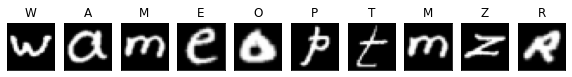

In [0]:
letters = [22, 0, 12, 4, 14, 15, 19, 12, 25, 17]

letter_locs = [np.where(np.argmax(Y_train, axis = 1) == i)[0][2] for i in letters]

#wameoptmzr

fig, ax = plt.subplots(1, 10, sharex='col', sharey='row', figsize=(10, 1))
for j in range(10):
  data = X_train[letter_locs[j]].reshape((28, 28))
  ax[j].imshow(data, cmap='gray')
  ax[j].tick_params(left=False, labelleft=False, bottom = False, labelbottom = False)
  ax[j].title.set_text('{label}'.format(label=string.ascii_uppercase[np.argmax(Y_train[letter_locs[j]])]))

## Create the model and tuner
Here we create the class to call a tuneable model, and import all the required functions and objects to run the tuning itself.


In [0]:
class MyHyperCNN(HyperModel):

  def __init__(self, num_classes):
    self.num_classes = num_classes

  def build(self, hp):
    model = Sequential()
    model.add(Reshape((28, 28, 1), input_shape=(784,)))
    model.add(Conv2D(64, (5, 5), input_shape=(28, 28, 1), activation = 'relu'))
    model.add(Conv2D(64, (1, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5), activation = 'relu'))
    model.add(Conv2D(128, (1, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Fully connected layer
    for i in range(hp.Int('num_layers', min_value = 1, max_value = 5, step = 1)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=256,
                                            max_value=1024,
                                            step=256),
                               activation='relu'))
        model.add(Dropout(hp.Float('units_drop_out' + str(i),
                                            min_value=0.4,
                                            max_value=0.6,
                                            step=0.1)))

    model.add(Dense(self.num_classes))
    model.add(Activation('softmax'))

    model.compile(optimizer= WAMEprop(learning_rate = hp.Float(
                    'learning_rate',
                    min_value=1e-3,
                    max_value=1e-1,
                    sampling='log',
                    default=1e-2
                ), name = 'wame'),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



## Create and run the tuner
First we create the tuner and check the search space, and then we run the tuner model itself, saving the output incase we get disconnected.

In [0]:
tuner = Hyperband(
    MyHyperCNN(26),
    max_epochs=30,
    objective='val_accuracy',
    seed=123,
    executions_per_trial=2,
    directory='hyperband',
    project_name='emnist_letters',
)

tuner.search_space_summary()

In [0]:
tuner.search(X_train,
          Y_train,
          batch_size = 1000,
          validation_data=(X_valid, Y_valid),
          verbose = 0
          )

tuner.results_summary()

pickle.dump(tuner, open( "/content/drive/My Drive/tuner1.p", "wb" ) )

INFO:tensorflow:Oracle triggered exit


In [0]:
tuner.results_summary()
print('#####################################')
tuner.get_best_hyperparameters()[0].values

#####################################


{'learning_rate': 0.07554544167531015,
 'num_layers': 2,
 'tuner/bracket': 2,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/round': 2,
 'tuner/trial_id': '049b099e1622eb30cc180fa5dd5b7c0f',
 'units_0': 768,
 'units_1': 768,
 'units_2': 256,
 'units_3': 1024,
 'units_4': 768,
 'units_drop_out0': 0.6,
 'units_drop_out1': 0.6,
 'units_drop_out2': 0.4,
 'units_drop_out3': 0.4,
 'units_drop_out4': 0.6}

## Tuner Analysis


In [0]:
tuner =pickle.load(open("/content/drive/My Drive/tuner1.p", "rb" ))
n_trails = 0
try:
  while True:
    temp = tuner.get_best_hyperparameters(10000000)[n_trails].values
    n_trails += 1
except:
  print("There were", n_trails, "trials")


There were 90 trials


In [0]:
tuner.results_summary()

## Create, train, evaluate final model
Here we create the final model, hard coding in the best parameters from the tuner, train the model, and then evaluate it on the test dataset.

In [0]:
def make_final_model(num_layers, n_neurons, dropouts, lr):
  model = Sequential()
  model.add(Reshape((28, 28, 1), input_shape=(784,)))
  model.add(Conv2D(64, (5, 5), input_shape=(28, 28, 1), activation = 'relu'))
  model.add(Conv2D(64, (1, 1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (5, 5), activation = 'relu'))
  model.add(Conv2D(128, (1, 1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  # Fully connected layer
  for i in range(num_layers):
    model.add(Dense(n_neurons[i]))
    model.add(Activation('relu'))
    model.add(Dropout(dropouts[i]))

  model.add(Dense(26))
  model.add(Activation('softmax'))

  model.compile(optimizer= WAMEprop(learning_rate = lr, name = 'wame'),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
  return model

models = [make_final_model(2, [768, 768], [0.6, 0.6], 0.07554544167531015),
          make_final_model(2, [512, 512], [0.4, 0.4], 0.0524485340749127),
          make_final_model(3, [512, 768, 768], [0.4, 0.5, 0.6], 0.02178803054091246),
          make_final_model(4, [768, 512, 256, 512], [0.5, 0.5, 0.6, 0.5], 0.022919907869005517),
          make_final_model(2, [256, 256], [0.4, 0.5], 0.07255565349251887)
]

model_names = []
for i in range(5):
  model_names.append('Best_' + str(i))

In [0]:
histories = []
for model, name in zip(models, model_names):
  print('Running model', name)
  tf.random.set_seed(123)
  random.seed(456)
  np.random.seed(789)

  #early stopping and checkpoints
  es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=25)
  mc = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/model_experiment_' + name +'.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True,)

  histories.append(model.fit(X_train,
            Y_train,
            epochs = 500,
            batch_size = 1000,
            validation_data=(X_valid, Y_valid),
            callbacks = [es, mc], 
            verbose = 0)
  )

Running model Best_0

Epoch 00001: val_accuracy improved from -inf to 0.92606, saving model to /content/drive/My Drive/model_experiment_Best_0.h5

Epoch 00002: val_accuracy improved from 0.92606 to 0.93313, saving model to /content/drive/My Drive/model_experiment_Best_0.h5

Epoch 00003: val_accuracy improved from 0.93313 to 0.93346, saving model to /content/drive/My Drive/model_experiment_Best_0.h5

Epoch 00004: val_accuracy improved from 0.93346 to 0.94409, saving model to /content/drive/My Drive/model_experiment_Best_0.h5

Epoch 00005: val_accuracy did not improve from 0.94409

Epoch 00006: val_accuracy did not improve from 0.94409

Epoch 00007: val_accuracy improved from 0.94409 to 0.94625, saving model to /content/drive/My Drive/model_experiment_Best_0.h5

Epoch 00008: val_accuracy improved from 0.94625 to 0.94644, saving model to /content/drive/My Drive/model_experiment_Best_0.h5

Epoch 00009: val_accuracy improved from 0.94644 to 0.94793, saving model to /content/drive/My Drive/m

TypeError: ignored

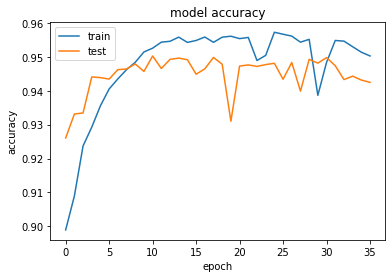

In [0]:
#visualise one of the model history
plt.plot(histories[0].history['accuracy'])
plt.plot(histories[0].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## All model basic eval

In [0]:
models = [make_final_model(2, [768, 768], [0.6, 0.6], 0.07554544167531015),
          make_final_model(2, [512, 512], [0.4, 0.4], 0.0524485340749127),
          make_final_model(3, [512, 768, 768], [0.4, 0.5, 0.6], 0.02178803054091246),
          make_final_model(4, [768, 512, 256, 512], [0.5, 0.5, 0.6, 0.5], 0.022919907869005517),
          make_final_model(2, [256, 256], [0.4, 0.5], 0.07255565349251887)
]

model_names = []
for i in range(5):
  model_names.append('Best_' + str(i))

for model, name in zip(models, model_names):
  model.load_weights('/content/drive/My Drive/model_experiment_' + name +'.h5')

In [0]:
y_preds_train = []
y_preds_val = []
y_preds_test = []
for model in models:
  y_preds_train.append(model.predict_classes(X_train))
  y_preds_val.append(model.predict_classes(X_valid))
  y_preds_test.append(model.predict_classes(X_test))

for train, val, test, i in zip(y_preds_train, y_preds_val,  y_preds_test, range(5)):
  print('Model', i, ':' 'Train:', accuracy_score(np.argmax(Y_train, axis = 1), train),
      'Val:',accuracy_score(np.argmax(Y_valid, axis = 1), val), 
      'Test:',accuracy_score(np.argmax(Y_test, axis = 1), test))

Model 0 :Train: 0.9665480769230769 Val: 0.9502884615384616 Test: 0.9463461538461538
Model 1 :Train: 0.9739711538461538 Val: 0.9520673076923077 Test: 0.9465865384615385
Model 2 :Train: 0.9737115384615385 Val: 0.9499519230769231 Test: 0.9459615384615384
Model 3 :Train: 0.9685384615384616 Val: 0.948701923076923 Test: 0.9452403846153846
Model 4 :Train: 0.9685480769230769 Val: 0.948173076923077 Test: 0.9457692307692308


## Model Evaluation

In [0]:
model = make_final_model(2, [512, 512], [0.4, 0.4], 0.0524485340749127)
model.load_weights('/content/drive/My Drive/model_experiment_Best_1.h5')

In [0]:
y_pred = model.predict_classes(X_test)
y_pred_prob = model.predict_proba(X_test)

In [0]:
print(accuracy_score(np.argmax(Y_test, axis = 1), y_pred))

0.9465865384615385


In [0]:
def top_n_accuracy(preds, truths, n):
  """ Thank you stackoverflow https://stackoverflow.com/questions/32461246/how-to-get-top-3-or-top-n-predictions-using-sklearns-sgdclassifier/48572046"""
  best_n = np.argsort(preds, axis=1)[:,-n:]
  ts = np.argmax(truths, axis=1)
  successes = 0
  for i in range(ts.shape[0]):
    if ts[i] in best_n[i,:]:
      successes += 1
  return float(successes)/ts.shape[0]

def top_n_recall_per_class(preds, truths, n, classes):
  n_classes = len(classes)
  best_n = np.argsort(preds, axis=1)[:,-n:]
  ts = np.argmax(truths, axis=1)
  successes = [0]*n_classes
  class_count = [0]*n_classes
  for i in range(ts.shape[0]):
    class_count[ts[i]] += 1
    if ts[i] in best_n[i,:]:
      successes[ts[i]] += 1
  return {k:v for k, v in zip(classes, [float(i)/float(j) for i, j in zip(successes, class_count)])}

In [0]:
recall1 = top_n_recall_per_class(y_pred_prob, Y_test, 1, string.ascii_uppercase)
recall3 =top_n_recall_per_class(y_pred_prob, Y_test, 3, string.ascii_uppercase)
recall5 =top_n_recall_per_class(y_pred_prob, Y_test, 5, string.ascii_uppercase)
rc1_df = pd.DataFrame.from_dict(recall1, orient = 'index', columns = ['Top 1'])
rc3_df = pd.DataFrame.from_dict(recall3, orient = 'index', columns = ['Top 3'])
rc5_df = pd.DataFrame.from_dict(recall5, orient = 'index', columns = ['Top 5'])
pd.concat([rc1_df, rc3_df, rc5_df], axis = 1)

,Top 1,Top 3,Top 5
A,0.97250,0.99625,0.99750
B,0.97375,0.99250,0.99375
C,0.97750,0.99250,0.99750
D,0.96250,0.99750,0.99875
E,0.97375,0.99000,0.99500
F,0.96000,0.99125,0.99625
G,0.84125,0.99500,0.99500
H,0.96375,0.99625,1.00000
I,0.76250,0.99250,0.99500
J,0.95250,0.99500,0.99875


[0.9465865384615385, 0.9907211538461539, 0.9945673076923077, 0.9961538461538462, 0.996875]


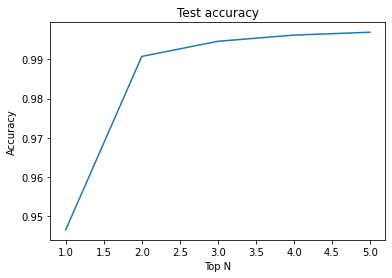

In [0]:
accuracy = []
for i in range(1, 6):
  accuracy.append(top_n_accuracy(y_pred_prob, Y_test, i))
print(accuracy)
plt.plot(range(1, 6), accuracy)
plt.title('Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Top N')
plt.show()

In [0]:
cm = confusion_matrix(np.argmax(Y_test, axis = 1), y_pred)

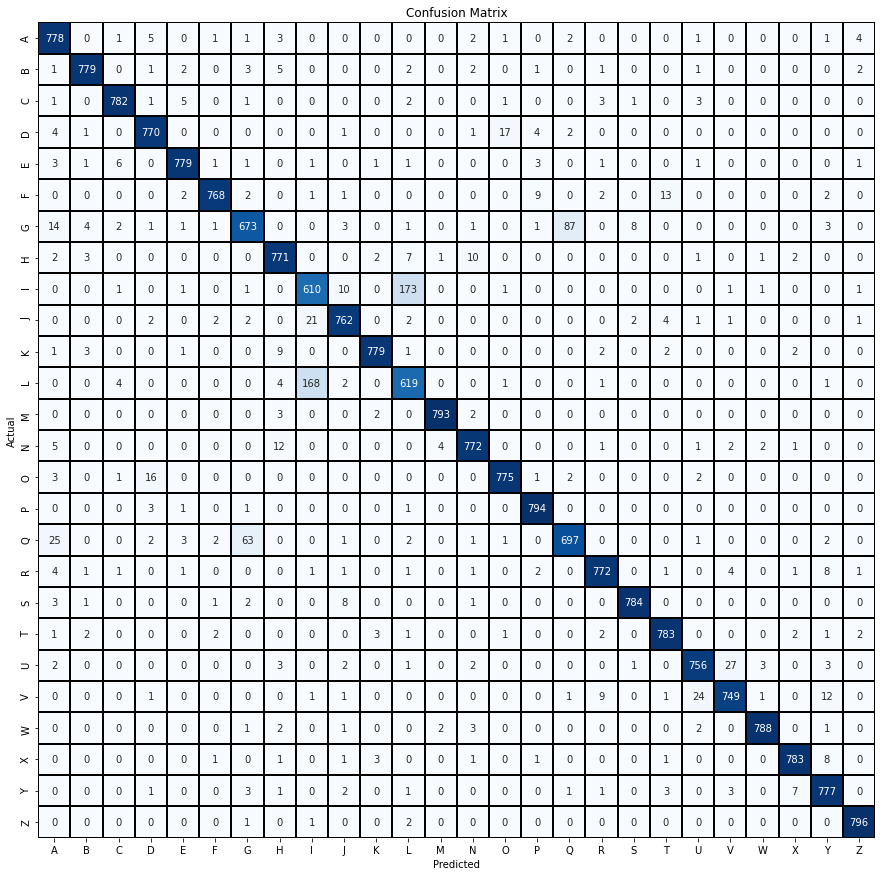

In [0]:
df_cm = pd.DataFrame(cm, index = [i for i in string.ascii_uppercase],
                  columns = [i for i in string.ascii_uppercase])
plt.figure(figsize = (15,15))
g = sn.heatmap(df_cm, annot=True, fmt='g', cmap = plt.cm.Blues, linewidths= 1, linecolor = 'black', cbar= False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

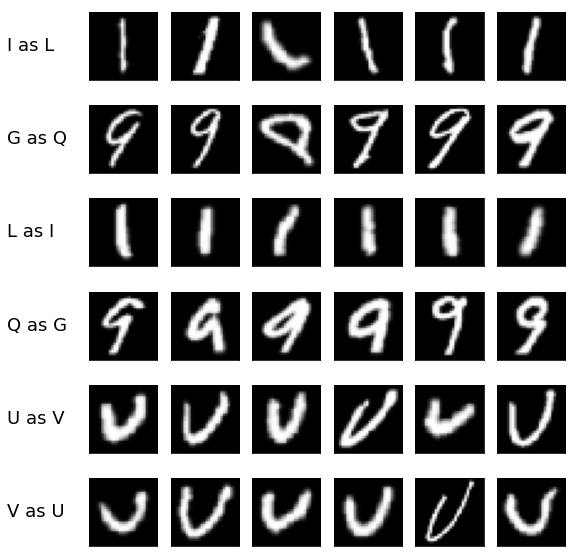

In [0]:
misclassified_i_as_l = np.where((np.argmax(Y_test, axis = 1) != y_pred) & (np.argmax(Y_test, axis = 1) == 8) & (y_pred == 11))
misclassified_g_as_q = np.where((np.argmax(Y_test, axis = 1) != y_pred) & (np.argmax(Y_test, axis = 1) == 6) & (y_pred == 16))
misclassified_l_as_i = np.where((np.argmax(Y_test, axis = 1) != y_pred) & (np.argmax(Y_test, axis = 1) == 11) & (y_pred == 8))
misclassified_q_as_g = np.where((np.argmax(Y_test, axis = 1) != y_pred) & (np.argmax(Y_test, axis = 1) == 16) & (y_pred == 6))
misclassified_u_as_v = np.where((np.argmax(Y_test, axis = 1) != y_pred) & (np.argmax(Y_test, axis = 1) == 20) & (y_pred == 21))
misclassified_v_as_u = np.where((np.argmax(Y_test, axis = 1) != y_pred) & (np.argmax(Y_test, axis = 1) == 21) & (y_pred == 20))

miss_list = [misclassified_i_as_l[0], misclassified_g_as_q[0], misclassified_l_as_i[0], misclassified_q_as_g[0], misclassified_u_as_v[0], misclassified_v_as_u[0]]
labels = ['I as L ', 'G as Q ', 'L as I ', 'Q as G ', 'U as V ', 'V as U ']

fig, ax = plt.subplots(6, 7, sharex='col', sharey='row', figsize=(10, 10))
for i in range(6):
  for j in range(7):
    if j != 0:
      data = X_test[miss_list[i][j]].reshape((28, 28))
      ax[i, j].imshow(data, cmap='gray')
      
    if j == 0:
      ax[i, j].text(0, 0.5, labels[i], fontsize=18, horizontalalignment='left', verticalalignment='center', transform=ax[i, j].transAxes)
      ax[i, j].axis('off')
    ax[i, j].tick_params(left=False, labelleft=False, bottom = False, labelbottom = False)


## Version Printing

In [0]:
import sys
from kerastuner import __version__ as ktver
from scipy import __version__ as spver
from matplotlib import __version__ as mlpver

print(np.__version__)
print(pd.__version__)
print(pickle.format_version)
print(tf.__version__)
print(spver)
print(mlpver)
print(ktver)
print(sys.version)

1.18.2
0.25.3
4.0
2.1.0
1.4.1
3.2.0
1.0.1
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
